# 6.1. КОГДА И ЦЕЛОГО ЛЕСА МАЛО

В прошлом модуле мы узнали об ансамблировании моделей. Одним из представителей такого подхода является случайный лес.

**Случайный лес**  — это композиция глубоких деревьев, которые строятся независимо друг от друга.

Такой подход имеет следующую проблему: обучение глубоких деревьев требует очень много вычислительных ресурсов, особенно в случае большой выборки или большого числа признаков.

Если ограничить глубину решающих деревьев в случайном лесе, то они уже не смогут улавливать сложные закономерности в данных. Это приведёт к тому, что сдвиг (**bias**) будет слишком большим.

### ПРИМЕР

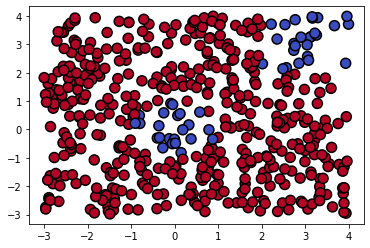

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_blobs, make_circles
import matplotlib.pyplot as plt
import numpy as np


%matplotlib inline

RANDOM_SEED = 139

def get_labels(data):
    labels = []
    for idx, item in enumerate(data):
        if item[0]**2 + item[1]**2 < 1:
            labels.append(0)
        elif item[0] > 2 and item[1] > 2:
            labels.append(0)
        else:
            labels.append(1)
    return np.array(labels)

N = 500
train_data = 7 * np.random.random_sample((N,2)) - np.array([3,3])

train_labels = get_labels(train_data)

# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

shallow_rf = RandomForestClassifier(n_estimators=5, max_depth=3, n_jobs=-1, 
                                    random_state=RANDOM_SEED)
deep_rf = RandomForestClassifier(n_estimators=5, max_depth=6, n_jobs=-1, 
                                 random_state=RANDOM_SEED)

# training the tree
shallow_rf.fit(train_data, train_labels)
deep_rf.fit(train_data, train_labels)

# some code to depict separating surface
xx, yy = get_grid(train_data)
predicted_shallow = shallow_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)
predicted_deep = deep_rf.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);

<ipython-input-2-9fd3e2ad3627>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[0].pcolormesh(xx, yy, predicted_shallow, cmap='coolwarm')
<ipython-input-2-9fd3e2ad3627>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[1].pcolormesh(xx, yy, predicted_deep, cmap='coolwarm')


Text(0.5, 1.0, 'Deep Random Forest')

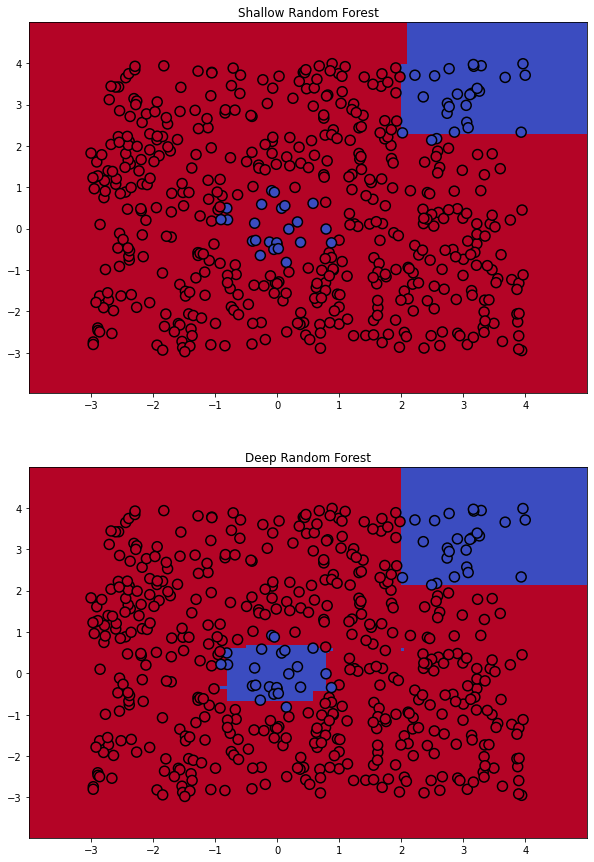

In [2]:
fig, ax = plt.subplots(2, 1, figsize=(10,15))

ax[0].pcolormesh(xx, yy, predicted_shallow, cmap='coolwarm')
ax[0].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[0].set_title('Shallow Random Forest')

ax[1].pcolormesh(xx, yy, predicted_deep, cmap='coolwarm')
ax[1].scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
            cmap='coolwarm', edgecolors='black', linewidth=1.5);
ax[1].set_title('Deep Random Forest')

# 6.4. Бустинг. Практика
## Задание 6.4.1
Для решения первого задания урока сначала подготовим данные. Выкачаем набор данных, в котором будет прогнозировать, является ли письмо спамом.

Сделаем это следующим кодом:

In [3]:
import pandas as pd

In [23]:
df = pd.read_csv('https://raw.githubusercontent.com/vincentarelbundock/Rdatasets/master/csv/DAAG/spam7.csv')

In [24]:
df.columns

Index(['Unnamed: 0', 'crl.tot', 'dollar', 'bang', 'money', 'n000', 'make',
       'yesno'],
      dtype='object')

Из столбца `yesno` сделайте столбец `spam`, где **1** соответствует значению **y** (является спамом), а **0** – **n** (не является спамом). Удалите первый столбец (с индексом) и столбец `yesno`.

У Вас остается шесть столбцов-признаков и один столбец spam, который является нашей целевой переменной. Разделим их на x и у.

In [25]:
df['spam'] = (df.yesno == 'y').astype(int)
df.drop(columns=['Unnamed: 0','yesno'],inplace = True)

In [26]:
X, y = df.drop(columns='spam'),df.spam

Теперь мы хотим создать новые признаки путем попарного перемножения уже имеющихся друг на друга. Сколько получится признаков после преобразования (включая те шесть, которые были в исходных данных)?

Комбинации признаков должны иметь вид **"признак1_признак2"**.

In [27]:
from sklearn.preprocessing import PolynomialFeatures

In [28]:
poly = PolynomialFeatures(degree=2,interaction_only=True, include_bias=False)
poly.fit(X)

poly_feature_names = poly.get_feature_names(input_features = X.columns)
poly_columns = [x.replace(' ','_') for x in poly_feature_names]

df_poly = pd.DataFrame(data = poly.fit_transform(X), columns=poly_columns)

In [29]:
ans = df_poly.shape[1]
ans

21

## Задание 6.4.2
Разделим получившися данные на обучающую и тестовую выборки в соотношение 80:20. Обучите модель `GradientBoostingClassifier` (из библиотеки `sklearn`) с параметрами по умолчанию (на момент создания урока это `learning_rate=0.1, n_estimators=100,max_depth=3, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features=None`).

Во всех методах, где присутствует случайность, укажите `random_state=42`.

Это будет наш **baseline**. Укажите точность  на тестовой выборке (параметр **score**), округлив до **третьего знака** после точки-разделителя.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df_poly,y,test_size=0.2,random_state=42)

In [31]:
gbc = GradientBoostingClassifier()

In [32]:
gbc.fit(X_train,y_train)

GradientBoostingClassifier()

In [33]:
ans = gbc.score(X_test,y_test)
round(ans,3)

0.866

Воспользуйтесь методом `feature_importances_`. С его помощью вы можете оценить вклад каждого признака в обучение модели. Постройте столбчатую диаграмму, где по горизонтали указаны названия признаков, а по вертикали их важность. В ответе укажите третий по важности признак (без кавычек и пробелов).

In [45]:
feat_imp = pd.Series(gbc.feature_importances_,index=df_poly.columns).sort_values(ascending=False)

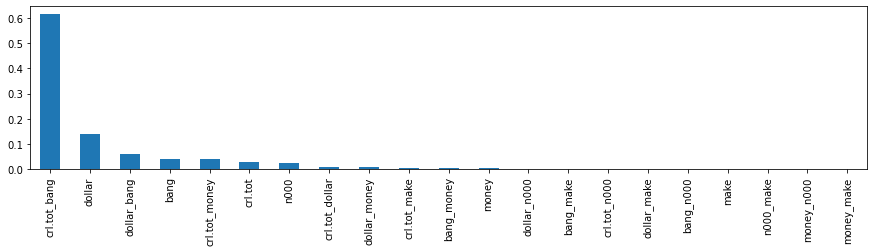

In [49]:
feat_imp.plot.bar(figsize=(15,3));

In [57]:
feat_imp.index[2]

'dollar_bang'

Теперь перейдем к подбору параметров в модели. Для этого в библиотеке `scikit-learn` есть метод` GridSearchCV`. Ему на вход подается модель, список параметров и способ оценивания. При запуске метода `fit` модель обучается со всеми возможными комбинациями параметров, лучшей комбинацией параметров становятся та, при которой значение метрики максимально.

Укажите в качестве `estimator` градиетный бустинг с параметрами по дефолту и `random_state=42`. В параметре `scoring` укажите `'accuracy', n_jobs=-1, cv=5`.

Сетку параметров задайте такой:
```
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}
```
В ответе укажите точность, округленную до Трёх знаков после точки разделителя, для лучших параметров на кросс-валидации. Для этого посмотрите в документации sklearn, какой атрибут GridSearchCV за это отвечает.

In [59]:
from sklearn.model_selection import GridSearchCV

In [74]:
param_grid = {'learning_rate':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
              'n_estimators':[100, 250, 500, 750, 1000, 1250, 1500, 1750]}
estimator = GradientBoostingClassifier(random_state=42,)


In [76]:
grid_search = GridSearchCV(estimator=estimator,
                           param_grid=param_grid,
                           scoring='accuracy',
                           n_jobs=-1, 
                           cv=5)

In [81]:
%%time
grid_search.fit(X_train,y_train)

Wall time: 4min 56s


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                         'n_estimators': [100, 250, 500, 750, 1000, 1250, 1500,
                                          1750]},
             scoring='accuracy')

In [82]:
ans = grid_search.best_score_
round(ans,3)

0.884

## Задание 6.4.3
Подбор параметров — незаменимый инструмент при настройке моделей. Однако, если данных очень много, а модель сложная, то иногда имеет смысл ограничить количество параметров, которые вы хотите перебрать. Если модель с одним набором параметров обучается 30 минут, а вы хотите перебрать 10 таких наборов, то стоит приготовиться к пятичасовому ожиданию. Также стоит учитывать, что размер некоторых параметров влияет на время, потраченное на обучение моделей. Например, менее глубокие деревья учатся быстрее, чем глубокие.

При использовании `GridSearchCV` перебираются все возможные способы комбинации параметров. Сколько разных моделей (моделей градиентного бустинга с разными наборами параметров) обучилось в прошлом задании?

In [97]:
len(param_grid['learning_rate'])*len(param_grid['n_estimators'])

48

Теперь воспользуемся `GridSearchCV` для подбора максимальной глубины (`max_depth`). В качестве `estimator` используйте градиентный бустинг с раннеее подобранными параметрами и `random_state=42`. Переберите все значения `max_depth` **от 5 до 15** включительно. В ответ запишите значение параметра, при котором точность максимальна.

In [95]:
estimator = grid_search.best_estimator_.set_params(random_state=42)

In [104]:
param_grid = {'max_depth':np.arange(5,16)}

In [107]:
grid_search = GridSearchCV(estimator=estimator, 
                           param_grid=param_grid,
                           n_jobs=-2)

In [108]:
%%time
grid_search.fit(X_train,y_train)

Wall time: 10min 54s


GridSearchCV(estimator=GradientBoostingClassifier(learning_rate=0.01,
                                                  n_estimators=1750,
                                                  random_state=42),
             n_jobs=-2,
             param_grid={'max_depth': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])})

In [109]:
grid_search.best_params_

{'max_depth': 5}

## Задание 6.4.4
Может показаться, что, научившись запускать готовые фукнции из библиотек и настраивать параметры, мы абсолютно готовы к работе. Однако на поле боя нас могут подстерегать еще опасности — legacy code, то есть код, написанный кем-то до вас. Может быть, его можно было бы и улучшить, но на нём уже столько всего надстроено, что переписывать всё практически невозможно.

А ещё часто будет возникать необходимость просто понять код коллеги или сделать code review (грубо говоря, это анализ кода на предмет ошибок и расхождения в стиле). Во всех этих ситуациях необходим навык быcтрого чтения кода.

Поэтому в качестве примера в этом задании мы предлагаем изучить код для реализации AdaBoost с нуля. Вам необходимо запустить эту функцию, но с дописанными строчками (вычисление ошибки и веса алгоритма) на всех признаках, получившихся после всех преобразований в предыдущем датасете (**до разделения выборки на обучающую и тестовую**). Параметр `learning_rate` возьмите равным **0.001**, **М = 10**. В ответ запишите точность, округленную до **трёх знаков** после точки-разделителя.

За основу нужно взять следующий код:
```
def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    # инициалиазция служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    # инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # цикл по длине М
    for m in range(M):   

        # обучим базовую модель и получим предсказание
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = (y_predict != y)

        # Оцениваем ошибку
        #estimator_error = TODO 
        
        # Вычисляем вес нового алгоритма
        #estimator_weight =  TODO

        # Получаем новые веса объектов
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        # Сохраяем результаты данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    # Для удобства переведем в numpy.array   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получим предсказания
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X, y, M=10, learning_rate=0.001)
```

In [140]:
def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    # инициалиазция служебных переменных
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    # инициализация весов
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    # цикл по длине М
    for m in range(M):   

        # обучим базовую модель и получим предсказание
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        # Маска для ошибок классификации
        incorrect = ~(y_predict != y)   # <===  ОШИБКА ЗДЕСЬ  ПРОВЕРИТЬ ВЕРССИИ БИБЛИОТЕКИ!!!

        # Оцениваем ошибку
        #estimator_error = TODO 
        estimator_error = sample_weight[incorrect].sum()
        
        # Вычисляем вес нового алгоритма
        #estimator_weight =  TODO
        estimator_weight = learning_rate * np.exp((1-estimator_error)/estimator_error)

        # Получаем новые веса объектов
        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        # Сохраяем результаты данной итерации
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        


    # Для удобства переведем в numpy.array   
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    # Получим предсказания
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

In [141]:
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(df_poly, y, M=10, learning_rate=0.001)

Accuracy =  0.8228645946533363


## 6.6. Стекинг. Практика

In [142]:
import pandas as pd
import numpy as np

from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.datasets import load_digits

from tqdm import tqdm

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats.distributions import randint

Все задания выполняются на основе датасета:

In [143]:
dataset = load_digits()
X, y = dataset['data'], dataset['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## Задание 6.6.1
В скринкасте мы разобрали схему генерации признаков в стекинге, когда для тестовой выборки алгоритм заново переобучался на всей тренировочной выборке. Реализуйте схему, когда вместо этого производится агрегация ответов всех обученных на фолдах классификаторов на тестовой выборке при помощи усреднения.

Логика решения:
1) Создадим `X_meta_test`, заполним его нулями (по аналогии с `X_meta_train`);
2) Далее на каждом шаге, где мы обучаем `folded_clf.fit (X_fold_train, y_fold_train)` и его предсказания на `X_fold_predict` запихиваем в `X_meta_train[predict_fold_index]`, добавим ещё одну строку, где в `X_meta_test` будем добавлять предсказания вероятностей `folded_clf` на `X_test`. Их можно сразу складывать друг с другом или сохранить много массивов, тогда в конце их нужно будет все сложить, а потом делить на количество сплитов (количество массивов равно количеству сплитов в кросс-валидации);
3) После цикла останется только усреднить все эти массивы — это и будет наш X_meta_test.
За основу нужно взять следующий код:
```
def compute_meta_feature_mean(clf, X_train, X_test, y_train, cv):
    """    Эта функция подсчитывает признаки для мета-классификатора.     Они являются вероятностями классов при решении задачи многоклассовой классификации.    :arg clf: классификатор    :args X_train, y_train: обучающая выборка    :arg X_test: признаки тестовой выборки    :arg cv: класс, генерирующий фолды (KFold)    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок    """
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)

    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)

    X_meta_test = meta_clf.predict_proba(X_test)

    return X_meta_train, X_meta_test
```

In [157]:
def compute_meta_feature_mean(clf, X_train, X_test, y_train, cv):
    """    Эта функция подсчитывает признаки для мета-классификатора.     
    Они являются вероятностями классов при решении задачи многоклассовой классификации.    
    :arg clf: классификатор    :args X_train, y_train: обучающая выборка    
    :arg X_test: признаки тестовой выборки    
    :arg cv: класс, генерирующий фолды (KFold)    
    :returns X_meta_train, X_meta_test: новые признаки для обучающей и тестовой выборок    
    """
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(X_train), n_classes), dtype=np.float32)
    X_meta_test = np.zeros((len(X_test), n_classes), dtype=np.float32)
    
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]

        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
        X_meta_test +=  folded_clf.predict_proba(X_test) / cv.n_splits

    return X_meta_train, X_meta_test

Для следующих заданий используйте этот код:
```python
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)
    
    return X_meta_train, X_meta_test
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.hstack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.hstack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test
cv = KFold(n_splits=10, shuffle=True, random_state=42)

def compute_metric(clf, X_train=X_train, y_train=y_train, X_test=X_test):
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    return np.round(f1_score(y_test, y_test_pred, average='macro'), 6)
```
ПОДСКАЗКА:
- Во всех случаях, когда модель принимает `random_state` — обязательно указывайте его равным **42**
- На разных версиях `sklearn` ответы могут отличаться
- В задании может понадобиться, а может не понадобиться нормализация и это нужно проверить во время решения задания.

## Задание 6.6.2
Используйте функцию generate_meta_features для стекинга следующих алгоритмов:
- логистическая регрессия с `L1-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — one-vs-rest, максимальное допустимое количество итераций — 2000`
- логистическая регрессия с `L2-регуляризацией, C=0.001, солвер — 'saga', схема работы мультиклассовой классификации — multinomial, максимальное допустимое количество итераций — 2000`
- случайный лес из `300 деревьев`
- градиентный бустинг из `200 деревьев`
Как мета-алгоритм используйте логистическую регрессию без регуляризации со схемой работы мультиклассовой классификации — `auto` и солвером `'lbfgs'`.
Посчитайте качество при помощи передачи новых признаков в функцию `compute_metric`.